# Image classification

This tutorial shows how to classify images of flowers. It creates an image classifier using a `tf.keras` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Keras Functional and Sequential API.
* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

> Bloque con sangría



```
flower_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [3]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

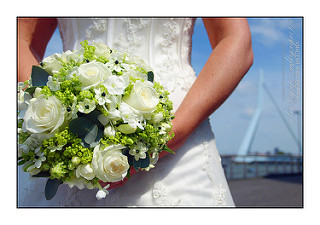

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

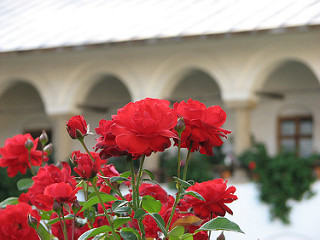

In [6]:
PIL.Image.open(str(roses[10]))

And some tulips:

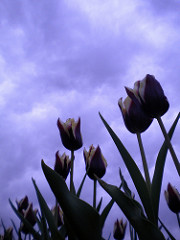

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

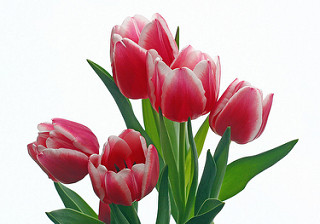

In [8]:
PIL.Image.open(str(tulips[1]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width), # imgs are resized after being read
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

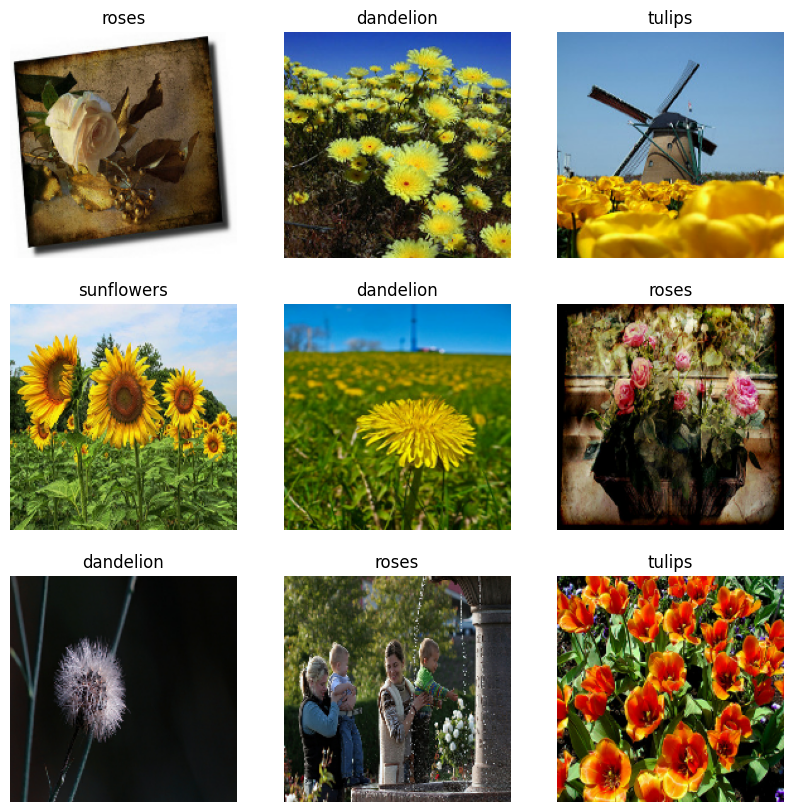

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32, 5)


In [15]:
image_batch[0][:,:, 2]

<tf.Tensor: shape=(180, 180), dtype=float32, numpy=
array([[200.38889  , 200.92778  , 199.21297  , ...,   0.2936081,
          5.1722207,   2.5083113],
       [202.27779  , 203.00833  , 206.15555  , ...,   9.163834 ,
          1.3749433,   4.155579 ],
       [206.02779  , 205.81944  , 209.87962  , ...,   8.26374  ,
         42.9172   , 168.2456   ],
       ...,
       [ 35.088005 ,  70.72218  ,  49.69902  , ...,  20.884245 ,
         35.249924 ,  29.092571 ],
       [ 42.572334 ,  59.832924 ,  43.816635 , ...,   2.5504522,
         11.400111 ,  14.036019 ],
       [ 40.034187 ,  38.9777   ,  40.50831  , ...,  20.565752 ,
         12.591592 ,  12.927795 ]], dtype=float32)>

In [16]:
labels_batch[0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalization_layer

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

## Sequential API

It allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.


In [22]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Functional API

Allows you to create models that have a lot more flexibility as you can easily define models where layers connect to more than just the previous and next layers. In fact, you can connect layers to (literally) any other layer. As a result, creating complex networks such as siamese networks and residual networks become possible.


In [23]:
num_classes = len(class_names)

input_l = layers.Input(shape=(img_height, img_width, 3))

x = layers.Rescaling(1./255)(input_l)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

output_l = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=input_l, outputs=output_l)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                        

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.CategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.


In [24]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                        

## Train the model

In [26]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 16s 51ms/step - loss: 1.5194 - accuracy: 0.3597 - val_loss: 1.2566 - val_accuracy: 0.4932
Epoch 2/10
92/92 [==============================] - 2s 22ms/step - loss: 1.0645 - accuracy: 0.5688 - val_loss: 1.1074 - val_accuracy: 0.5518
Epoch 3/10
92/92 [==============================] - 2s 22ms/step - loss: 0.8398 - accuracy: 0.6737 - val_loss: 0.9837 - val_accuracy: 0.6199
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.6405 - accuracy: 0.7646 - val_loss: 1.0923 - val_accuracy: 0.6172
Epoch 5/10
92/92 [==============================] - 2s 22ms/step - loss: 0.4452 - accuracy: 0.8457 - val_loss: 1.2627 - val_accuracy: 0.5831
Epoch 6/10
92/92 [==============================] - 2s 22ms/step - loss: 0.2848 - accuracy: 0.9026 - val_loss: 1.2815 - val_accuracy: 0.6022
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.1547 - accuracy: 0.9496 - val_loss: 1.5703 - val_accuracy: 0.6090
Epoch 8/10
9

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

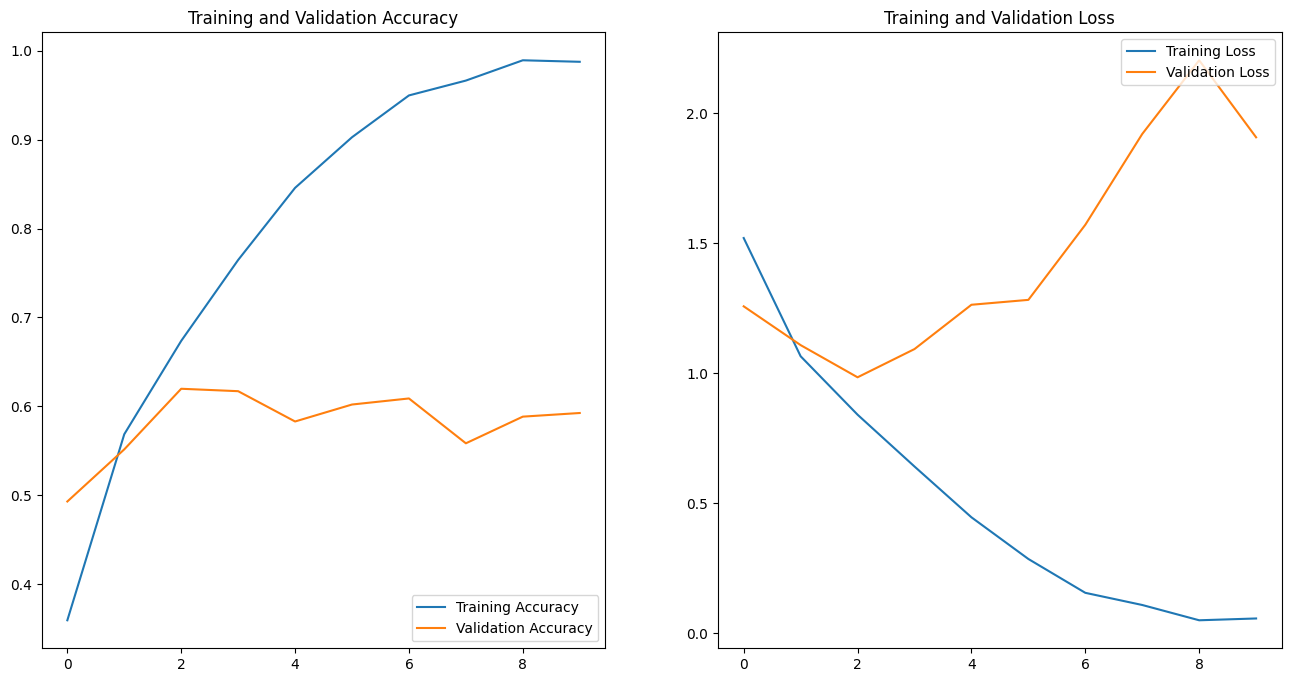

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

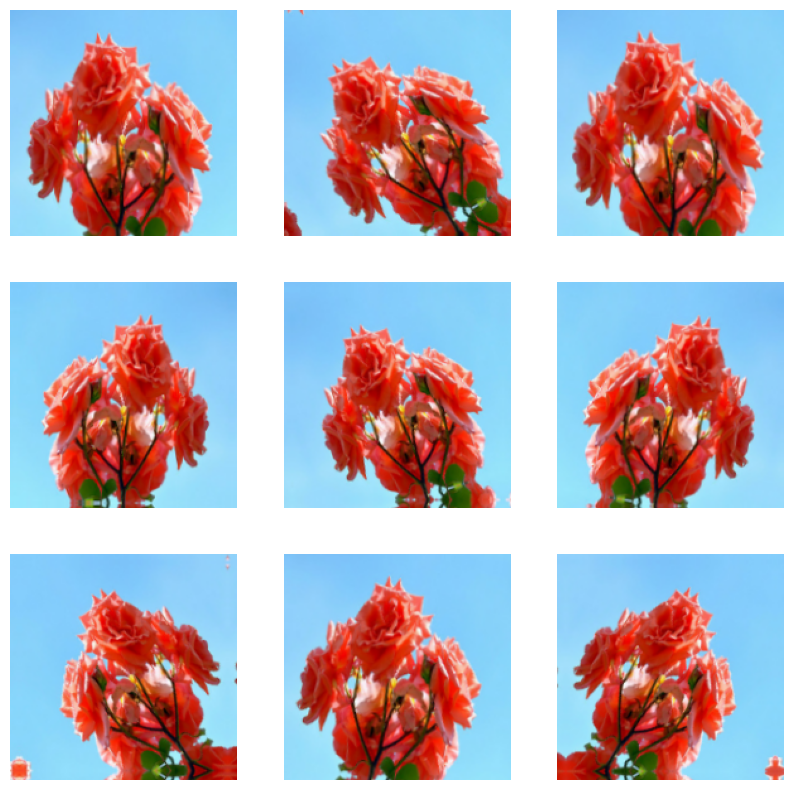

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
num_classes = len(class_names)

input_l = layers.Input(shape=(img_height, img_width, 3))

x = data_augmentation(input_l)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.L2(l2=1e-4))(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(l2=1e-4))(x)

output_l = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.L2(l2=1e-4))(x)

model = keras.Model(inputs=input_l, outputs=output_l)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                           

## Compile and train the model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Using Callbacks during training

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

You can use callbacks to:

- Write TensorBoard logs after every batch of training to monitor your metrics
- Periodically save your model to disk
- Do early stopping
- Get a view on internal states and statistics of a model during training
...and more

See full Keras documentation at [Callbacks API](https://keras.io/api/callbacks/).


In [ ]:
my_callbacks = [
    callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.h5'),
    callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=my_callbacks,
)


Epoch 1/15
92/92 [==============================] - 5s 34ms/step - loss: 1.3021 - accuracy: 0.4506 - val_loss: 1.0965 - val_accuracy: 0.5845
Epoch 2/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0797 - accuracy: 0.5811 - val_loss: 1.0681 - val_accuracy: 0.5845
Epoch 3/15
92/92 [==============================] - 3s 30ms/step - loss: 0.9822 - accuracy: 0.6315 - val_loss: 0.9481 - val_accuracy: 0.6512
Epoch 4/15
92/92 [==============================] - 3s 29ms/step - loss: 0.9131 - accuracy: 0.6645 - val_loss: 1.0214 - val_accuracy: 0.6308
Epoch 5/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8923 - accuracy: 0.6686 - val_loss: 0.9521 - val_accuracy: 0.6444
Epoch 6/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8382 - accuracy: 0.6945 - val_loss: 0.8552 - val_accuracy: 0.6853
Epoch 7/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8108 - accuracy: 0.7108 - val_loss: 0.8184 - val_accuracy: 0.7016
Epoch 8/15
92

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

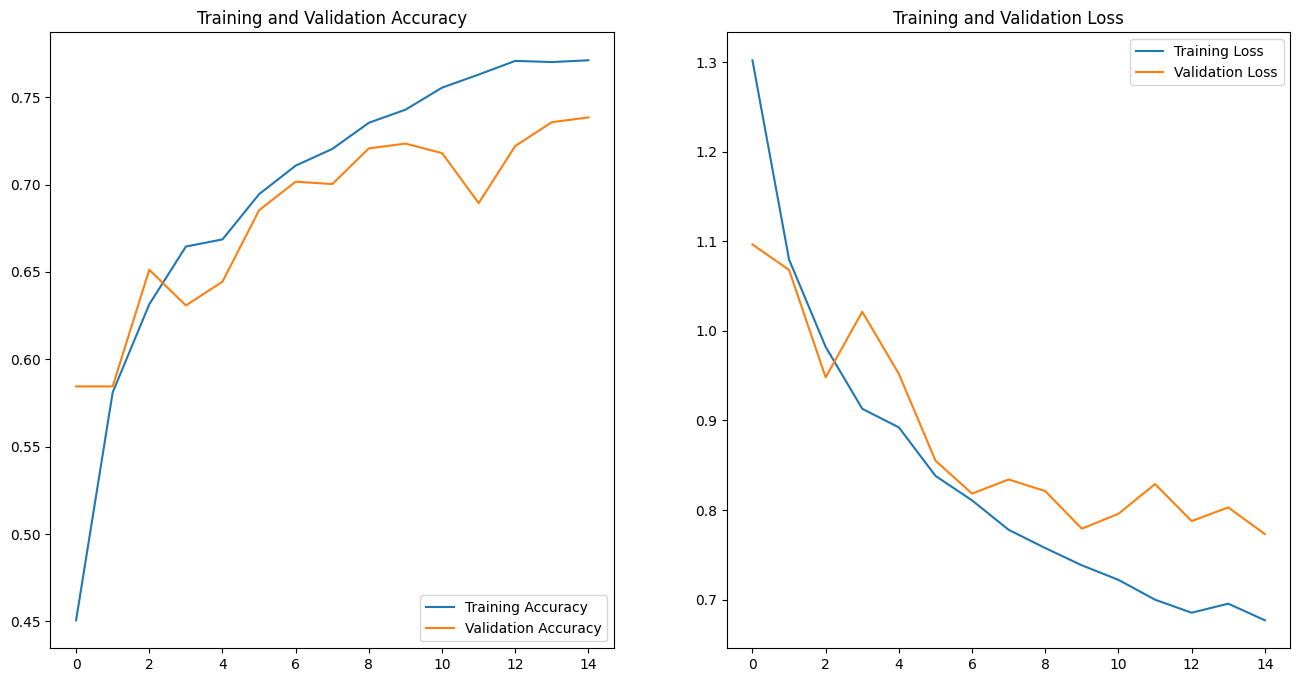

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

117948/117948 [==============================] - 0s 2us/step


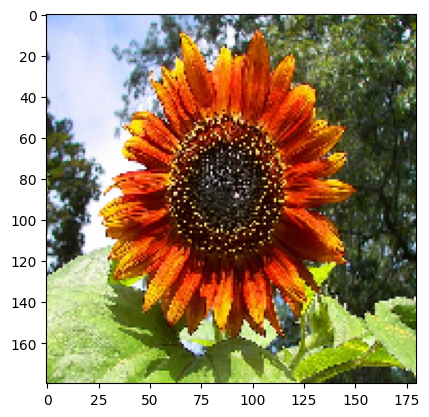

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array / 255)

In [ ]:
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

print(f"Model predictions: {predictions}")

# Get the position with highest score in output predictions
max_idx = np.argmax(predictions)
# Get the max score
max_score = predictions[0][max_idx]
# Get the class name
predicted_class = class_names[max_idx]


print(
    f"This image most likely belongs to '{predicted_class}' with a {max_score:.2f} confidence score."
)

1/1 [==============================] - 0s 269ms/step
Model predictions: [[2.8420920e-06 2.5367918e-03 6.3523762e-03 9.1369420e-01 7.7413887e-02]]
This image most likely belongs to 'sunflowers' with a 0.91 confidence score.
